In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from dice_loss import *
from unet import *

from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

# STEPS=2000
STEPS = 50
EPOCHS=2
# EPOCHS = 1
MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [3]:
image_generator_train = ImageDataGenerator(
    rotation_range=2,
    rescale=1./255,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator_train = ImageDataGenerator(
    rotation_range=2,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

image_generator_test = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

label_generator_test = ImageDataGenerator(
    # No rescale transform on target mask
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

In [4]:
train_generator = generator(
    TRAIN_PATH,
    image_generator_train,
    label_generator_train
)
test_generator = generator(
    TEST_PATH,
    image_generator_test,
    label_generator_test
)

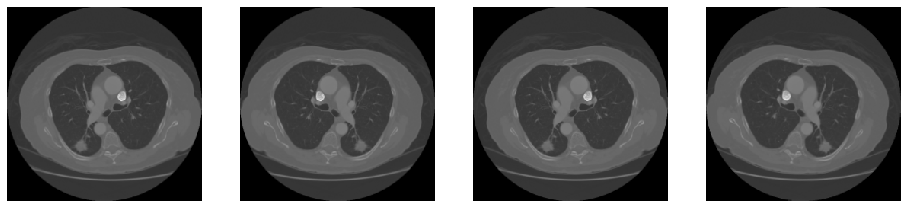

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


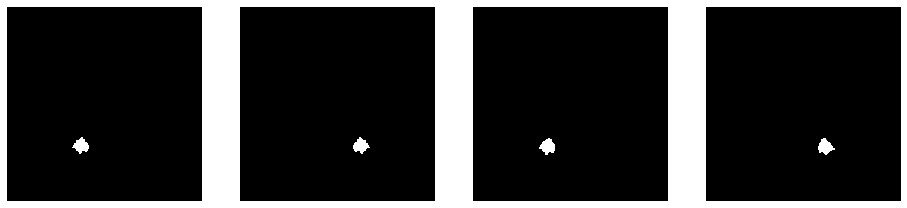

In [5]:
show_augmentation('data/train/image1/1.png', image_generator_train, n_rows=1)
show_augmentation('data/train/label1/1.png', label_generator_train, n_rows=1)

## Instantiate and Train the U-Net

In [6]:
model = unet()
model.compile(
    optimizer = Adam(lr = 1e-4),
    loss=dice_coef_loss,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.
        metrics.TruePositives()
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=1, save_best_only=True)

In [7]:
model.fit_generator(
  train_generator,
  steps_per_epoch = 8,
  epochs = 2
)

Epoch 1/2
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv3D]

## Test the U-Net

In [ ]:
X_test = np.array([np.load(f'data/test/image/{f}') for f in os.listdir('data/test/image')])
y_test = np.array([np.load(f'data/test/label/{f}') for f in os.listdir('data/test/label')])

X_test = np.array([x.reshape(256, 256, 4, 1) for x in X_test]).astype('float')
X_test = np.array([y.reshape(256, 256, 4, 1) for y in X_test]).astype('float')

In [ ]:
# results = model.predict(X_test, 2, verbose=1)

results = model.predict(X_train[0].reshape(1, 256, 256, 4, 1), 2, verbose=1)


# Visualize test results

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(X_train[0].reshape(4, 256, 256)[0], cmap='bone')
axs[1].imshow(y_train[0].reshape(4, 256, 256)[0], cmap='bone')
axs[2].imshow(results[0].reshape(4, 256, 256)[0], cmap='bone')
plt.show()